## SVM, Kernelisation

---

In [143]:
import numpy as np
np.random.seed(0)
from numpy.matlib import repmat
import sys
import time
from l2distance import l2distance
import visclassifier
import matplotlib
import matplotlib.pyplot as plt
import traceback

import pylab
from matplotlib.animation import FuncAnimation

#new torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#misc imports
import random

# %matplotlib notebook
%matplotlib inline

<h3>Introduction</h3>
In this project, you will implement a linear support vector machine and one operating in kernel space. For this you will need to formulate the primal and dual optimization problems as quadratic programs. For this, we will be dipping into the shallow end with Course staffs' favorite ML framework: PyTorch!

For full documentation and details, here is their site https://pytorch.org/. PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. Pytorch is very neat because, as you have seen your assignments, in order to do gradient descent we've had to calculate gradient manually. No more! Pytorch performs automatic differentation, as long as we use their functions in our code.

Note: Because we are working with Pytorch functions and Modules, we will be using excusively Pytorch tensors instead of numpy arrays. This allows us to multiply/use torch parameter objects with our data directly. Pytorch tensors carry most of the same functionality as numpy arrays.

We will start with a simple example of PyTorch, where we use gradient descent to find the parameters of a simple linear regression problem.

In [144]:
def gen_regression_data(num_samples = 10000, ndims=1):
    # generate random x samples for training and test sets
    xTr = torch.rand(num_samples, ndims)
    xTe = torch.rand(int(num_samples * 0.1), ndims)
    
    # construct random w and b vectors
    gt_w = torch.randn(ndims, 1)
    gt_b = torch.randn(1)
    
    # gaussian noise for linear regression
    noise = np.random.rand(num_samples, 1) * 0.2
    test_noise = np.random.rand(int(num_samples * 0.1), 1) * 0.2
    
    # add noise on the labels for the training set
    yTr = xTr @ gt_w + gt_b + noise
    yTe = xTe @ gt_w + gt_b + test_noise
    
    return xTr, xTe, yTr, yTe, gt_w, gt_b

In [145]:
lr_xTr, lr_xTe, lr_yTr, lr_yTe, gt_w, gt_b = gen_regression_data(num_samples = 1000, ndims=1)

Now we will create our PyTorch model. PyTorch models inherit the class torch.nn.module, and you need to implement the function forward which is equivalent to a forward pass. Usually, you feed in batch of x samples as input and you get batch of outputs, but you could pass other parameters as well if needed. Every torch module will implement two functions. __init__ its constructor, and __forward__ which defines what happens when you call the module.

Note we define two fields of the <code>LinearRegressionModel</code>:
* <code>self.w</code>: The weight vector of the linear regression model. This is updated automatically by Pytorch in our training loop because we define it as a nn.Parameter (note requires_grad=True). Additionally <code>torch.randn(ndims, 1)</code> gives us an initialization for this weight vector.
* <code>self.b</code>: The bias of the linear regression model. This is also updated automatically by Pytorch in our training loop.

In [146]:
class LinearRegressionModel(nn.Module):
    def __init__(self, ndims):
        super(LinearRegressionModel, self).__init__()
        """ pytorch optimizer checks for the properties of the model, and if
            the torch.nn.Parameter requires gradient, then the model will update
            the parameters automatically.
        """
        self.w = nn.Parameter(torch.randn(ndims, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
    
    def forward(self, x):
        return x @ self.w + self.b

For this example we use our familiar mean-squared error loss.

In [147]:
def mse_loss(y_pred, y_true):
    square_diff = torch.square((y_pred-y_true))
    mean_error = 0.5 * torch.mean(square_diff)
    return mean_error

Here is a generic training loop in Pytorch, this will be very useful for you in your assignment. We have supplied comments per line to help walk you through what each different part does.

In [148]:
def train_regression_model(xTr, yTr, num_epochs, reg_param, lr=1e-2, print_freq=100):
    ndims = xTr.shape[1]
    
    model = LinearRegressionModel(ndims)  # initialize the model
    optimizer = optim.SGD(model.parameters(), lr=lr)  # create an SGD optimizer for the model parameters
    
    for epoch in range(num_epochs):
        # need to zero the gradients in the optimizer so we don't
        # use the gradients from previous iterations
        optimizer.zero_grad()  
        pred = model.forward(xTr)  # compute model predictions
        loss = mse_loss(pred, yTr) + reg_param * torch.norm(model.w)
        loss.backward()  # compute the gradient wrt loss
        optimizer.step()  # performs a step of gradient descent
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    
    return model  # return trained model

In [150]:
model = train_regression_model(lr_xTr, lr_yTr, num_epochs=2000, reg_param=0.001, lr=1e-2)
avg_test_error = mse_loss(model.forward(lr_xTe), lr_yTe)
print('avg test error', avg_test_error.item())

epoch 100 loss 0.06386028268750575
epoch 200 loss 0.049769199336276077
epoch 300 loss 0.043449887570597874
epoch 400 loss 0.03836873322398342
epoch 500 loss 0.03394064976342393
epoch 600 loss 0.03005251743705575
epoch 700 loss 0.026636274779183986
epoch 800 loss 0.02363445366233755
epoch 900 loss 0.02099676653946446
epoch 1000 loss 0.01867905603356735
epoch 1100 loss 0.016642486001438927
epoch 1200 loss 0.014852949480399379
epoch 1300 loss 0.01328051233896685
epoch 1400 loss 0.011898812689445162
epoch 1500 loss 0.010684725963874266
epoch 1600 loss 0.009617909438061357
epoch 1700 loss 0.00868049678389739
epoch 1800 loss 0.007856807153421016
epoch 1900 loss 0.007133030938390298
epoch 2000 loss 0.0064970539413137735
avg test error 0.006333182703012311


Now, we have a trained model object that we can predict with by passing in input data via model.forward(x). Let's visualize how good of a fit our line is to the data!

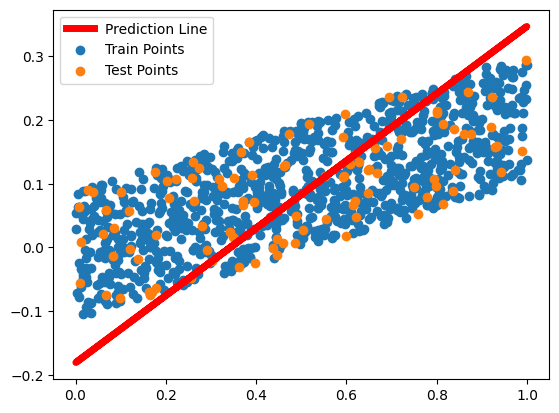

In [151]:
plt.plot(lr_xTr, model.forward(lr_xTr).detach(),linewidth=5.0, color="red", label="Prediction Line")
plt.scatter(lr_xTr, lr_yTr, label="Train Points")
plt.scatter(lr_xTe, lr_yTe, label="Test Points")
plt.legend()
plt.show()

For the following assignment there are a bunch of PyTorch specfic functions that we believe will be very helpful for you. Those are:

* <code>torch.clamp(input, min=None, max=None, *, out=None) </code>: Clamps all elements in input into the range [min, max]

* <code>torch.sum(input, *, dtype=None) </code>: Returns the sum of all elements in the input tensor.

* <code>torch.mean(input, *, dtype=None)</code>: Returns the mean value of all elements in the input tensor.

* <code>torch.pow(input, exponent, *, out=None)</code>: Takes the power of each element in input with exponent and returns a tensor with the result.

* <code>torch.exp(input, *, out=None)</code>: Returns a new tensor with the exponential of the elements of the input tensor.

<h3> Linear classification</h3>

<p> The first part of the assignment is to implement a linear support vector machine. In order to do this, we are going to generate random data to classify:
</p>

In [152]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly separable labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return torch.from_numpy(xTr).float(), torch.from_numpy(yTr).float()

Remember the SVM primal formulation
$$\begin{aligned}
             &\min_{\mathbf{w},b,\xi} \|\mathbf{w}\|^2_2+C \sum_{i=1}^n \xi_i\\
       & \text{such that }  \ \forall i:\\
             & y_i(\mathbf{w}^\top \mathbf{x}_i+b)\geq 1-\xi_i\\
             & \xi_i\geq 0.\\
\end{aligned}
$$
You will need to implement  the function <code>primalSVM</code>, which takes in training data <code>xTr</code> ($n\times d$) and labels <code>yTr</code> ($n$) with <code>yTr[i]</code>$\in \{-1,1\}$. Note that we aren't doing linear programming, this is gradient descent optimization so the constraints are something we do not worry about.

To warm up, implement <code>hinge_loss</code>, which calculates the loss described in $\sum_{i=1}^n \xi_i$. Working with torch tensors is a lot like working with numpy tensors, think about the best way to do tensor on tensor operations. <b>This method requires no loops</b>.

Hint: <code>torch.clamp</code> might be useful here

In [153]:
def hinge_loss(y_pred, y_true):
    
    hinge = torch.clamp(1 - y_pred * y_true, min=0)
    mean_error = torch.sum(hinge)
    return mean_error

Next, implement <code>LinearSVM</code>. This is a module (similar to the one in the example above) which initializes a linear classifer in dimension <code>dim</code>. In this module, you will need to initialize the necessary parameters for a linear model and define the forward pass for an input x. Hint: It <b>should</b> look very similar to what you have done before.

In [154]:
class LinearClassifier(nn.Module):
    """Support Vector Machine"""

    def __init__(self, dim):
        
        super(LinearClassifier, self).__init__()
        """ pytorch optimizer checks for the properties of the model, and if
            the torch.nn.Parameter requires gradient, then the model will update
            the parameters automatically.
        """
        self.w = nn.Parameter(torch.randn(dim, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        
        return (x @ self.w + self.b).squeeze()

Finally, implement <code>primalSVM</code>. This is a method which takes in a set of training data <code>xTr</code> and labels <code>yTr</code>, a number of epochs <code>num_epochs</code> to train for, and our SVM <code>C</code> hyper-parameter. You should return a lambda function (https://www.w3schools.com/python/python_lambda.asp) <code>svmclassify</code> that produces a forward pass of your trained model.

In [155]:
def primalSVM(xTr, yTr, num_epochs=1000, C=1):
    
    n, dim = xTr.shape
    net = LinearClassifier(dim)
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    losses = torch.zeros(num_epochs)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = net.forward(xTr)
        loss = C*hinge_loss(pred, yTr)
        losses[epoch] = loss
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % (num_epochs / 10) == 0:
            print('epoch {} loss {}'.format(epoch+1, torch.mean(losses[:epoch]).item()))
    # print(losses)
    return lambda x: net(x)


We can test your SVM primal solver with the following randomly generated data set. We label it in a way that it is guaranteed to be linearly separable. If your code works correctly the hyper-plane should separate all the $x$'s into the red half and all the $o$'s into the blue half. With sufficiently large values of $C$ (e.g. $C>10$) you should obtain $0\%$ training error. 

epoch 100 loss 62.62575149536133
epoch 200 loss 48.188167572021484
epoch 300 loss 41.87303161621094
epoch 400 loss 38.172664642333984
epoch 500 loss 35.59892654418945
epoch 600 loss 33.56573486328125
epoch 700 loss 31.838485717773438
epoch 800 loss 30.28645133972168
epoch 900 loss 28.926563262939453
epoch 1000 loss 27.66008949279785


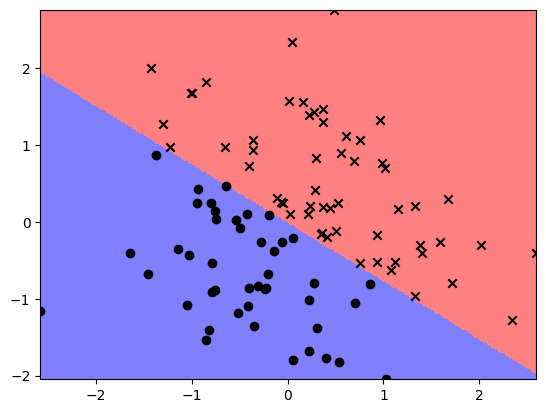

Training error: 0.0%


In [156]:
xTr,yTr = genrandomdata()
fun = primalSVM(xTr,yTr, C=15)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean((torch.sign(fun(xTr))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

<h3>Spiral data set</h3>

<p>The linear classifier works great in simple linear cases. But what if the data is more complicated? We provide you with a "spiral" data set. You can load it and visualize it with the following two code snippets:
<pre>

In [159]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    xTr = torch.tensor(xTr).float()
    yTr = torch.tensor(yTr).float()
    xTe = torch.tensor(xTe).float()
    yTe = torch.tensor(yTe).float()
    
    vals, indices = torch.max(xTr, dim=0, keepdim=True)
    xTr /= (vals * 2.0)
    vals, indices = torch.max(xTe, dim=0, keepdim=True)
    xTe /= (vals * 2.0)
    
    return xTr,yTr,xTe,yTe

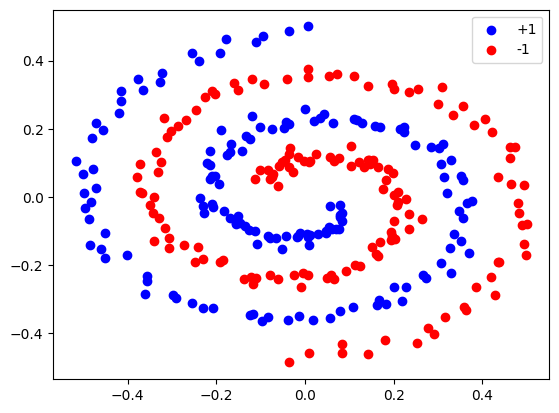

In [160]:
xTr,yTr,xTe,yTe=spiraldata()
plt.figure()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

<p>If you apply your previously functioning linear classifier on this data set you will see that you get terrible results. Your training error will increase drastically. </p>

In [161]:
a = torch.tensor([1,0,1])
a.all()

tensor(False)

epoch 100 loss 9724.734375
epoch 200 loss 9739.0732421875
epoch 300 loss 9748.2763671875
epoch 400 loss 9748.2431640625
epoch 500 loss 9742.162109375
epoch 600 loss 9745.359375
epoch 700 loss 9745.2548828125
epoch 800 loss 9747.1904296875
epoch 900 loss 9748.8408203125
epoch 1000 loss 9745.7421875


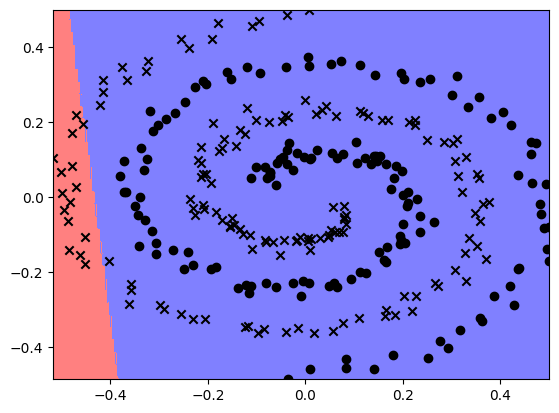

Training error: 45.0%


In [162]:
fun=primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean(((torch.sign(fun(xTr)))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

<h3>Implementing a kernelized SVM</h3>

For a data set as complex as the spiral data set, you will need a more complex classifier. 
First implement the kernel function
<pre>	computeK(kernel_type,X,Z,kpar)</pre>
It takes as input a kernel type <code>kernel_type</code> and two data sets $\mathbf{X} \in \mathcal{R}^{n\times d}$ and $\mathbf{Z} \in \mathcal{R}^{m\times d}$ and outputs a kernel matrix $\mathbf{K}\in{\mathcal{R}^{n\times m}}$. The last input, <code>kpar</code> specifies the kernel parameter (e.g. the inverse kernel width $\gamma$ in the RBF case or the degree $p$ in the polynomial case.)
	<ol>
	<li>For the linear kernel (<code>kernel_type='linear'</code>) svm, use $k(\mathbf{x},\mathbf{z})=x^Tz$ </li> 
	<li>For the radial basis function kernel (<code>kernel_type='rbf'</code>) svm use $k(\mathbf{x},\mathbf{z})=\exp(-\gamma ||x-z||^2)$ (gamma is a hyperparameter, passed as the value of kpar)</li>
	<li>For the polynomial kernel (<code>kernel_type='poly'</code>) use  $k(\mathbf{x},\mathbf{z})=(x^Tz + 1)^d$ (d is the degree of the polymial, passed as the value of kpar)</li>
</ol>

<p>You can use the function <b><code>l2distance</code></b> as a helperfunction, which is located in defined in one of your starter files l2distance.py.</p>

In [163]:
def computeK(kernel_type, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kernel_type: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel Torch float tensor
    """
    assert kernel_type in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kernel_type
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    # YOUR CODE HERE
    # K = torch.zeros(X.shape[0], Z.shape[0])
    if kernel_type == "linear":
        K = torch.mm(X, Z.T)
    if kernel_type == "polynomial" or kernel_type == "poly":
        kpar = 2 if kpar < 2 else kpar
        kpar = int(kpar) # may need to add more safety checks
        K = (torch.mm(X, Z.T) + 1)** kpar
    if kernel_type == "rbf":
        K = torch.exp(-kpar * l2distance(X,Z)**2)
    return K

<h3>Additional Testing</h3>
<p>The following code snippet plots an image of the kernel matrix for the data points in the spiral set. Use it to test your <b><code>computeK</code></b> function:</p>

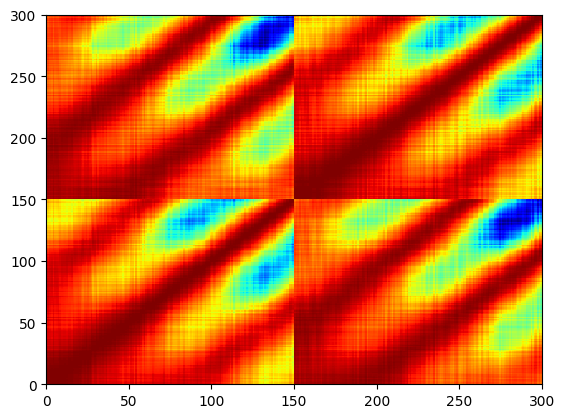

In [167]:
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
# plot an image of the kernel matrix
plt.figure()
plt.pcolormesh(K, cmap='jet')
plt.show()

Remember that the SVM optimization has the following dual formulation: (1)
$$
\begin{aligned}
             &\min_{\alpha_1,\cdots,\alpha_n}\frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{K}_{ij} - \sum_{i=1}^{n}\alpha_i  \\
       \text{s.t.}  &\quad 0 \leq \alpha_i \leq C\\
             &\quad \sum_{i=1}^{n} \alpha_i y_i = 0.
\end{aligned}
$$
This is equivalent to solving for the SVM primal (2)
$$ L(\mathbf{w},b) = C\sum_{i=1}^n \max(1-y_i(\mathbf{w}^\top\phi(\mathbf{x}_i)+b),0) + ||w||_2^2$$
where $\mathbf{w}=\sum_{i=1}^n y_i \alpha_i \phi(\mathbf{x}_i)$ and $\mathbf{K}_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)=\phi(\mathbf{x}_i)^\top\phi(\mathbf{x}_j)$, for some mapping $\phi(\cdot)$. However, after a change of variable, with $\beta_i = \alpha_iy_i$ and $\beta \in R^n$, (2) can be rewritten as follows (see https://arxiv.org/pdf/1404.1066.pdf for details):
$$ min_{\beta, b} \frac{1}{2}\beta^\top K\beta + \frac{C}{2}\sum_{i=1}^n {[\max(1-y_i(\beta^\top k_i+b),0)]}^2$$
where $k_i$ is the kernel matrix row corresponding to the ith training example. Notice that there are two relaxations: 1. the $\beta_i$ are unconstrained, in contrast to $\alpha_i$ in (1), which must satisfy $0 \leq \alpha_i \leq C$; and 2. the squared hinge loss is used in place of the more common absolute hinge loss.



Implement the module 
<pre>
KernelizedSVM(dim, kernel_type, kpar=0)
</pre>
This is a kernelized version of the SVM as defined above, which must maintain some kind of internal parameters for beta and b (hint: think what <code>dim</code> should be as a function of our training data) should be used for. Further, you are given <code>kernel_type</code> and <code>kpar</code>, which you should use in the creation of kernels by means of the method you wrote above <code>computeK</code>. For the forward pass of the kernelized SVM, recall that it is defined as $h(x) = w^\top \phi(x) + b$, where $w = \sum_{i=1}^n \beta_i\phi(x_i)$. The output of your forward pass should be the classification itself of input data x.


In [168]:
class KernelizedSVM(nn.Module):
    def __init__(self, dim, kernel_type, kpar=0):
        
        super(KernelizedSVM, self).__init__()

        # self.w = nn.Parameter(torch.randn(dim, 1), requires_grad=True)
        self.kernel_type = kernel_type
        self.kpar = kpar
        self.beta = nn.Parameter(torch.randn(dim,1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, xTr, x):
        
        self.kernel_mat = computeK(self.kernel_type, xTr, x, self.kpar)
        # return (self.beta.T @ self.kernel_mat) + self.b
        return (torch.sign((self.beta.T @ self.kernel_mat) + self.b)).squeeze()


Implement the function 
<pre>
kernelsvm_loss(kernelizedSVM, kernel_mat, yTr, C)
</pre>
It should implement the loss function described above for the equivalent primal formulation of the dual:
$$ min_{\beta, b} \frac{1}{2}\beta^\top K\beta + \frac{C}{2}\sum_{i=1}^n {[\max(1-y_i(\beta^\top k_i+b),0)]}^2$$
You are given a KernalizedSVM module (<code>kernelizedSVM</code>) which you defined above, the kernel (<code>kernel_mat</code>), the training labels (<code>yTr</code>), and the regularizatin paramater (<code>C</code>). 
 
Note that this function <b>requires no loops</b>, and that you may find two functions especially helpful 
* <code>F.relu(x)</code> computes the <code>max(x,0)</code> in a way that allows for our optimizers to work (F is torch.nn.Functional, a library imported above) 
* <code>torch.square(x)</code> Returns a new tensor with the square of the elements of input.


In [169]:
def kernelsvm_loss(kernelizedSVM, kernel_mat, yTr, C):
    
    beta = (kernelizedSVM.beta).reshape(-1,1)
    loss1 = 0.5 * beta.T @ kernel_mat @ beta
    loss2 = 0.5 * C * torch.sum( torch.square( F.relu( 1 - yTr * ( (beta.T @ kernel_mat + kernelizedSVM.b) )) ) )
    cumulative_loss = loss1 + loss2
    return cumulative_loss

<p>
    Implement the function 
    <pre>
    dualSVM(xTr, yTr, kernel_type, num_epochs, C, kpar, lr)
    </pre>
    It should use your functions <code><b>kernelsvm_loss</b></code>, <code><b>computeK</b></code>, and <code><b>KernelizedSVM</b></code> to solve the SVM dual problem of an SVM specified by a training data set (<code><b>xTr,yTr</b></code>), a regularization parameter (<code>C</code>), a kernel type (<code>ktype</code>) and kernel parameter (<code>lmbda</code>), to be used as kpar in Kernel construction. This will once again be a training loop similar to the primalSVM above. You should return a lambda function <code>svmclassify</code> that produces a forward pass of your trained model.
</p>

In [170]:
def dualSVM(xTr, yTr, kernel_type, num_epochs=100, C=1, lmbda=0, lr=1e-3):
    
    n, d = xTr.shape
    net = KernelizedSVM(n, kernel_type, kpar=lmbda)
    optimizer = optim.SGD(net.parameters(), lr=lr)


    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = net.forward(xTr, xTr)
        loss = kernelsvm_loss(net, net.kernel_mat, yTr, C)
        loss.backward()
        optimizer.step()

        if torch.isnan(loss) or torch.isinf(loss):
            break
        if (epoch + 1) % 100 == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))


    return lambda x: net(xTr, x)

    # return svmclassify

<h3>Testing</h3>
<p>Now we try the SVM with RBF kernel on the spiral data. If you implemented it correctly, train and test error should be close to zero.</p>

epoch 100 loss 71.3751220703125
epoch 200 loss 48.172645568847656
epoch 300 loss 40.243534088134766
epoch 400 loss 36.88911819458008
epoch 500 loss 34.931278228759766
epoch 600 loss 33.63664245605469
epoch 700 loss 32.707374572753906
epoch 800 loss 31.99301528930664
epoch 900 loss 31.41931915283203
epoch 1000 loss 30.946741104125977


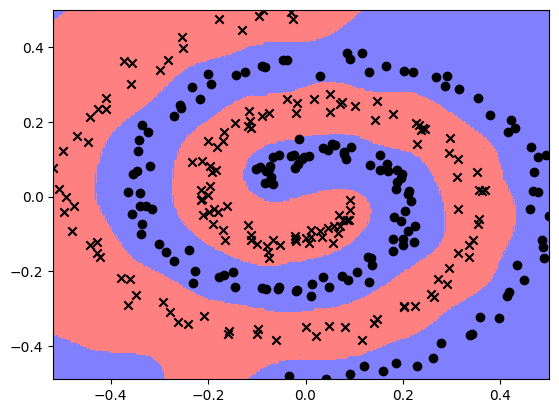

Training error: 0.0000
Testing error: 0.0100


In [171]:
xTr,yTr,xTe,yTe=spiraldata()

# poly kernel parameters that don't blow up vvv
# ktype="poly"
# svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=10, C=0.1, lmbda=0.05, lr=1e-4)
# visclassifier.visclassifier(svmclassify,xTr,yTr)

# linear kernel parameters that also don't blow up vvv
# ktype="linear"
# svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=10, C=0.1, lmbda=0.05, lr=1e-4)
# visclassifier.visclassifier(svmclassify,xTr,yTr)

# rbf kernel with parameters that achieve perfect accuracy vvv 
ktype="rbf"
svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=1000, C=1, lmbda=100, lr=1e-3)
visclassifier.visclassifier(svmclassify,xTr,yTr)

# compute training and testing error
predsTr=svmclassify(xTr)
trainingerr=torch.mean((torch.sign(predsTr)!=yTr).float())
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=torch.mean((torch.sign(predsTe)!=yTe).float())
print("Testing error: %2.4f" % testingerr)

In [255]:
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList,lr_List):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
        lr_list  | The list of values to try for the learning rate of our optimizer
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        bestLr     | the best Lr parameter
        ErrorMatrix| the test error rate for each given (C, Lmbda Lr) tuple when trained on (xTr,yTr) and tested on (xValid,yValid)
    """
    
    n, d = xTr.shape
    if ktype == "rbf":
        lmbdaList1 = 1 / np.array(lmbdaList)

    losses_val = np.zeros((len(CList), len(lmbdaList), len(lr_List)))
    ErrorMatrix = np.zeros((len(CList), len(lmbdaList), len(lr_List)))
    for ci, c in enumerate(CList):
        for lmbi, lmbda in enumerate(lmbdaList1):
            for lri, lr in enumerate(lr_List):

                model = dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=1000, C=c, lmbda=lmbda, lr=lr)
                
                with torch.no_grad():
                    pred = model(xValid)
                
                ErrorMatrix[ci, lmbi, lri] = torch.mean((torch.sign(pred)!=yValid).float())
    
    bestC_idx, bestLmbda_idx, bestLr_idx = np.unravel_index(np.argmin(ErrorMatrix, axis=None), ErrorMatrix.shape)
    bestC = CList[bestC_idx]
    bestLmbda = lmbdaList[bestLmbda_idx]
    bestLr = lr_List[bestLr_idx]                

    return bestC,bestLmbda,bestLr,ErrorMatrix, losses_val

<h3>Testing</h3>

In [256]:
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-1,5,7))
lmbdaList=(np.linspace(0.1,0.5,5))
lrList=(np.linspace(0.001,0.005,5))

bestC,bestLmbda,bestLr,ErrorMatrix, losses = cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList,lrList)

epoch 100 loss 31.041486740112305
epoch 200 loss 27.534255981445312
epoch 300 loss 26.248205184936523
epoch 400 loss 25.60224151611328
epoch 500 loss 25.21611976623535
epoch 600 loss 24.960704803466797
epoch 700 loss 24.77987289428711
epoch 800 loss 24.644981384277344
epoch 900 loss 24.539979934692383
epoch 1000 loss 24.455368041992188
epoch 100 loss 25.530431747436523
epoch 200 loss 24.95597267150879
epoch 300 loss 24.672542572021484
epoch 400 loss 24.496328353881836
epoch 500 loss 24.372982025146484
epoch 600 loss 24.279417037963867
epoch 700 loss 24.204334259033203
epoch 800 loss 24.141658782958984
epoch 900 loss 24.087812423706055
epoch 1000 loss 24.04059600830078
epoch 100 loss 26.673694610595703
epoch 200 loss 25.496463775634766
epoch 300 loss 24.96068572998047
epoch 400 loss 24.644084930419922
epoch 500 loss 24.431882858276367
epoch 600 loss 24.277976989746094
epoch 700 loss 24.160303115844727
epoch 800 loss 24.066925048828125
epoch 900 loss 23.990779876708984
epoch 1000 loss 23

In [177]:
CList

array([ 0.5,  1. ,  2. ,  4. ,  8. , 16. , 32. ])

In [257]:
bestC, bestLmbda, bestLr

(0.5, 0.2, 0.001)